In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyref.fitting as fit
from refnx.analysis import Transform

# Load the Data Files


In [ ]:
df = (
    pl.read_parquet("june_processed.parquet")
    .sort(pl.col("Q"))
    .sort(pl.col("pol"), descending=True)
)
df = df.filter(pl.col("sample").str.starts_with("mono"))

display(df.head())
data = {}
for en, g in df.group_by("Beamline Energy [eV]", maintain_order=True):
    Q = g["Q"].to_numpy()
    R = g["r"].to_numpy()
    # Calculate initial dR
    dR = 0.08 * R + 0.5e-6 * Q
    # Ensure dR doesn't exceed 90% of R to keep R-dR positive
    dR = np.minimum(dR, 0.9 * R)
    ds = fit.XrayReflectDataset(data=(Q, R, dR))
    data[str(en[0])] = ds
energy_batches = [
    np.array([250, 275, 283.7, 284.2]),  # Structure
    df["Beamline Energy [eV]"].unique().to_numpy(),  # fixed structure
]
display(energy_batches[1])

Beamline Energy [eV],sample,pol,bt,Q,r
f64,str,str,str,f64,f64
283.7,"""monolayer""","""s""","""june""",0.0,1.0
275.0,"""monolayer""","""s""","""june""",0.001012,0.932947
280.0,"""monolayer""","""s""","""june""",0.00103,0.860302
281.0,"""monolayer""","""s""","""june""",0.001034,0.71063
281.2,"""monolayer""","""s""","""june""",0.001035,0.81888


array([250. , 275. , 280. , 281. , 281.2, 281.4, 281.6, 281.8, 282. ,
       282.3, 282.5, 282.7, 282.9, 283.1, 283.3, 283.5, 283.7, 284.2,
       285.1, 287. , 289. ])

# Load Optical Constants for Constraints and OOC instantiation


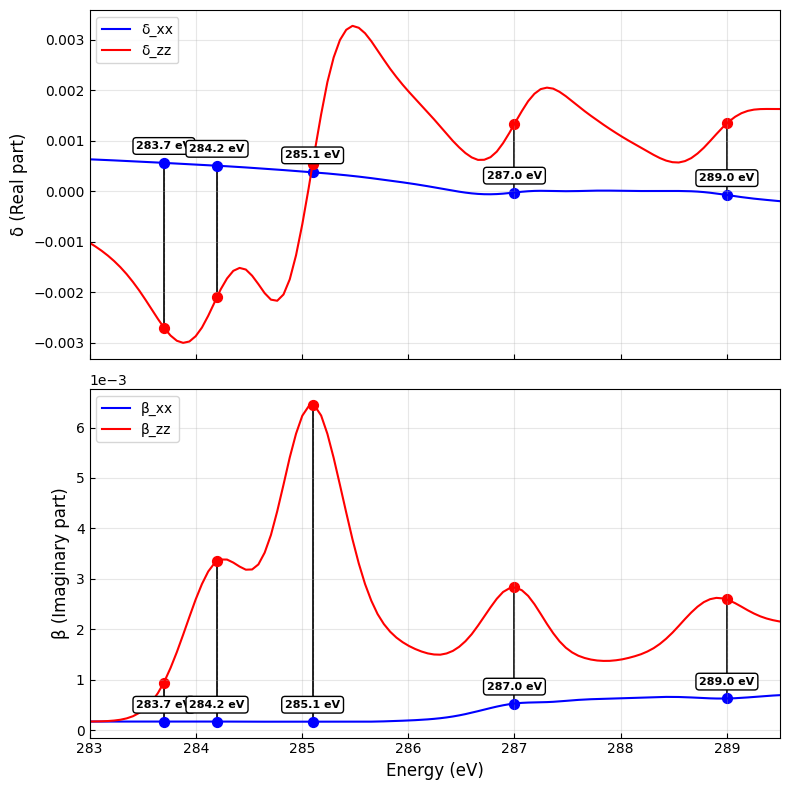

In [ ]:
import numpy as np

ooc = pd.read_csv("optical_constants.csv")

# Define energy_batches for the example
energy_batches = [
    np.array([250.0, 275.0, 283.7, 284.2]),
    np.array(
        [
            250.0,
            275.0,
            280.0,
            281.0,
            281.2,
            281.4,
            281.6,
            281.8,
            282.0,
            282.3,
            282.5,
            282.7,
            282.9,
            283.1,
            283.3,
            283.5,
            283.7,
            284.2,
            285.1,
            287.0,
            289.0,
        ]
    ),
]


def ooc_function(energy, ooc=ooc, theta=0.0, density=1.0):
    """Get optical constants for a given energy."""
    #  return the interpolated values for a given energy
    n_xx = np.interp(energy, ooc["energy"], ooc["n_xx"]) * density
    n_zz = np.interp(energy, ooc["energy"], ooc["n_zz"]) * density
    n_ixx = np.interp(energy, ooc["energy"], ooc["n_ixx"]) * density
    n_izz = np.interp(energy, ooc["energy"], ooc["n_izz"]) * density
    #  Rotate by theta
    if theta != 0.0:
        n_xx, n_zz = (
            0.5 * (n_xx * (1 + np.cos(theta) ** 2) + n_zz * np.sin(theta) ** 2),
            n_xx * np.sin(theta) ** 2 + n_zz * np.cos(theta) ** 2,
        )
        n_ixx, n_izz = (
            0.5 * (n_ixx * (1 + np.cos(theta) ** 2) + n_izz * np.sin(theta) ** 2),
            n_ixx * np.sin(theta) ** 2 + n_izz * np.cos(theta) ** 2,
        )
    return n_xx, n_zz, n_ixx, n_izz


def plot_optical_constants_with_energies(
    ooc,
    energy_batches,
    en_shift=-0.0,
    label=True,
    theta=0.0,
    density=1.0,
    show_theta_range=False,
):
    """
    Plot optical constants with energy markers and return figure and axes.

    Parameters:
    -----------
    ooc : pandas.DataFrame
        DataFrame containing optical constants data
    energy_batches : list
        List of energy arrays to mark on the plot
    """

    ooc_func = lambda e: ooc_function(e, ooc=ooc, theta=theta, density=density)  # noqa: E731
    if show_theta_range:
        ooc_func_low = lambda e: ooc_function(e, ooc=ooc, theta=0, density=density)  # noqa: E731
        ooc_func_high = lambda e: ooc_function(  # noqa: E731
            e, ooc=ooc, theta=np.pi / 2, density=density
        )

    # Create a cleaner plot with better layout - stacked vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    emin = min(energy_batches) + en_shift - 10
    emax = max(energy_batches) + en_shift + 10
    # Create energy array for plotting
    energy_plot = np.linspace(emin, emax, 1000)

    # Calculate optical constants using ooc_func
    n_xx_plot = []
    n_zz_plot = []
    n_ixx_plot = []
    n_izz_plot = []

    for energy in energy_plot:
        n_xx, n_zz, n_ixx, n_izz = ooc_func(energy)
        n_xx_plot.append(n_xx)
        n_zz_plot.append(n_zz)
        n_ixx_plot.append(n_ixx)
        n_izz_plot.append(n_izz)

    # Plot the main curves
    ax1.plot(energy_plot, n_xx_plot, "b-", linewidth=1.5, label="δ_xx")
    ax1.plot(energy_plot, n_zz_plot, "r-", linewidth=1.5, label="δ_zz")
    ax1.set_ylabel("δ (Real part)", fontsize=12)
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(direction="in")

    ax2.plot(energy_plot, n_ixx_plot, "b-", linewidth=1.5, label="β_xx")
    ax2.plot(energy_plot, n_izz_plot, "r-", linewidth=1.5, label="β_zz")

    #  fill between for theta range if specified
    if show_theta_range:
        n_xx_low_plot = []
        n_xx_high_plot = []
        n_ixx_low_plot = []
        n_ixx_high_plot = []

        for energy in energy_plot:
            n_xx_low, _, n_ixx_low, _ = ooc_func_low(energy)
            n_xx_high, _, n_ixx_high, _ = ooc_func_high(energy)
            n_xx_low_plot.append(n_xx_low)
            n_xx_high_plot.append(n_xx_high)
            n_ixx_low_plot.append(n_ixx_low)
            n_ixx_high_plot.append(n_ixx_high)

        ax1.fill_between(
            energy_plot,
            n_xx_low_plot,
            n_xx_high_plot,
            color="blue",
            alpha=0.1,
        )

        ax2.fill_between(
            energy_plot,
            n_ixx_low_plot,
            n_ixx_high_plot,
            color="blue",
            alpha=0.1,
        )

    ax2.set_ylabel("β (Imaginary part)", fontsize=12)
    ax2.set_xlabel("Energy (eV)", fontsize=12)
    ax2.legend(loc="upper left")
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(direction="in")
    ax2.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

    # Draw vertical lines at the measurement energies
    if not label:
        plt.tight_layout()
        return fig, (ax1, ax2)

    for i, e in enumerate(energy_batches):
        if e < 283.7:
            continue
        n_xx, n_zz, n_ixx, n_izz = ooc_func(e)
        n_xx_shifted, n_zz_shifted, n_ixx_shifted, n_izz_shifted = ooc_func(
            e + en_shift
        )
        ax1.vlines(
            e,
            ymin=min(n_xx, n_zz),
            ymax=max(n_xx, n_zz),
            color="gray",
            linestyle="--",
            linewidth=0.8,
            alpha=0.5,
            zorder=0,
        )
        ax2.vlines(
            e,
            ymin=min(n_ixx, n_izz),
            ymax=max(n_ixx, n_izz),
            color="gray",
            linestyle="--",
            linewidth=0.8,
            alpha=0.5,
            zorder=0,
        )

        # Energy-shifted energies (solid red lines)
        ax1.vlines(
            e + en_shift,
            ymin=min(n_xx_shifted, n_zz_shifted),
            ymax=max(n_xx_shifted, n_zz_shifted),
            color="k",
            linestyle="-",
            linewidth=1.2,
            zorder=0,
        )
        ax2.vlines(
            e + en_shift,
            ymin=min(n_ixx_shifted, n_izz_shifted),
            ymax=max(n_ixx_shifted, n_izz_shifted),
            color="k",
            linestyle="-",
            linewidth=1.2,
            zorder=0,
        )

        ax1.scatter(
            e + en_shift,
            n_xx_shifted,
            color="blue",
            marker="o",
            s=50,
            label=f"δ_xx at {e + en_shift} eV",
        )
        ax1.scatter(
            e + en_shift,
            n_zz_shifted,
            color="red",
            marker="o",
            s=50,
            label=f"δ_zz at {e} eV",
        )
        ax2.scatter(
            e + en_shift,
            n_ixx_shifted,
            color="blue",
            marker="o",
            s=50,
            label=f"β_xx at {e} eV",
        )
        ax2.scatter(
            e + en_shift,
            n_izz_shifted,
            color="red",
            marker="o",
            s=50,
            label=f"β_zz at {e + en_shift} eV",
        )
        # if the energy is >= 283.7 eV annotate the point with a box and bold text
        if e >= 283.7:
            ax1.annotate(
                f"{e + en_shift:.1f} eV",
                (e + en_shift, n_xx_shifted),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
                fontsize=8,
                bbox=dict(
                    boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"
                ),
                fontweight="bold",
            )
            ax2.annotate(
                f"{e + en_shift:.1f} eV",
                (e + en_shift, n_ixx_shifted),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
                fontsize=8,
                bbox=dict(
                    boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"
                ),
                fontweight="bold",
            )
    # Adjust layout
    plt.tight_layout()

    return fig, (ax1, ax2)


# Call the function and show the plot
fig, axes = plot_optical_constants_with_energies(
    ooc, energy_batches[1], en_shift=-0.0, theta=0, show_theta_range=False
)
for ax in axes:
    ax.set_xlim(283, 289.5)
plt.show()
en_shift = 0.0  # Energy shift for the optical constants plot
offset_energies = [energy_batches[0] + en_shift, energy_batches[1] + en_shift]

In [ ]:
ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))


def setp_from_tensor(slab, tensor):
    """Set parameters from tensor."""
    rbounds = (
        tensor.real.min() * 0.9,
        tensor.real.max() * 1.1,
    )
    ibounds = (
        1e-8,
        tensor.imag.max() * 1.1,
    )
    slab.sld.xx.setp(vary=True, bounds=rbounds)
    slab.sld.zz.setp(vary=True, bounds=rbounds)
    slab.sld.ixx.setp(vary=True, bounds=ibounds)
    slab.sld.izz.setp(vary=True, bounds=ibounds)
    return slab


def force_isotropic_beta(slab):
    """Force beta to be isotropic."""
    slab.sld.beta.setp(vary=True, bounds=slab.sld.ixx.bounds)
    slab.sld.ixx.setp(vary=None, constraint=slab.sld.beta)
    slab.sld.izz.setp(vary=None, constraint=slab.sld.beta)


def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, thick=0, rough=1.2, density=2.44):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False, bounds=(2, 3))
    return slab


def sio2(energy, thick=10.1, rough=4, density=2.15):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=True, bounds=(8, 12))
    slab.rough.setp(vary=True, bounds=(0, 8))
    slab.sld.density.setp(vary=False, bounds=(1, 2.3))
    return slab


def contamination(energy, thick=4.4, rough=2, density=1.0):
    """Contamination."""
    name = f"Contamination_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.81, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(np.pi / 4, 7 * np.pi / 8))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def surface(energy, thick=3.3, rough=1, density=1.0):
    """Surface."""
    name = f"Surface_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.8, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 4))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab

    if energy > 275 and energy < 283:
        force_isotropic_beta(slab)

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def znpc(energy, thick=191, rough=8.8, density=1.61):
    """ZnPc."""
    name = f"ZnPc_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=1.35, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1.2, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(MA, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(180, 210))
    slab.rough.setp(vary=True, bounds=(2, 16))
    return slab


def construct_slab(
    energy,
    offset=0,
):
    """Construct the slab."""
    offset_energy = round(energy + offset, 1)
    slab = (
        vacuum(offset_energy)
        | surface(offset_energy)
        | znpc(offset_energy)
        | contamination(offset_energy)
        | sio2(offset_energy)
        | substrate(offset_energy)
    )
    slab.name = f"Monolayer_{energy + offset}"
    return slab


stacks = {
    str(round(e + en_shift, 1)): construct_slab(e, en_shift) for e in energy_batches[1]
}
stacks.keys()

dict_keys(['250.0', '275.0', '280.0', '281.0', '281.2', '281.4', '281.6', '281.8', '282.0', '282.3', '282.5', '282.7', '282.9', '283.1', '283.3', '283.5', '283.7', '284.2', '285.1', '287.0', '289.0'])

# Fit Delta Crossing to consistent slab model


In [ ]:
def safely_setp(slab, param, **kwargs):
    """Safely set parameters."""
    #  Check if the vary = True while the constraint is not None
    if kwargs.get("vary", False) and kwargs.get("constraint") is not None:
        kwargs["vary"] = None
    if hasattr(slab, param):
        getattr(slab, param).setp(**kwargs)

In [ ]:
#  Constrain the thickness and roughness of each layers to match between energies
for e in energy_batches[1]:
    if e == 283.7:
        continue
    if e > 280 and e < 283:
        # Set the surface and substrate beta to be constrained to 280.0 values
        safely_setp(
            stacks[str(e)][1].sld,
            "density",
            vary=None,
            constraint=stacks["280.0"][1].sld.density,
        )
        safely_setp(
            stacks[str(e)][3].sld,
            "density",
            vary=None,
            constraint=stacks["280.0"][3].sld.density,
        )
    for i, slab in enumerate(stacks[str(round(e, 1))]):
        slab.thick.setp(vary=None, constraint=stacks["283.7"][i].thick)
        slab.rough.setp(vary=None, constraint=stacks["283.7"][i].rough)
        safely_setp(
            slab.sld, "density", vary=None, constraint=stacks["283.7"][i].sld.density
        )
        safely_setp(
            slab.sld, "rotation", vary=None, constraint=stacks["283.7"][i].sld.rotation
        )

In [ ]:
models = {
    str(e): fit.ReflectModel.build_model(e, stacks[str(e)], data[str(e)])
    for e in energy_batches[1]
}
for model in models.values():
    # Constrain the energy offset to be the same for all models
    if model.name.endswith("283.7"):
        model.energy_offset.setp(vary=True, bounds=(-0.5, 0.5))
    else:
        model.energy_offset.setp(vary=None, constraint=models["283.7"].energy_offset)
objectives = [
    fit.AnisotropyObjective.build_objective(models[str(e)], data[str(e)])
    for e in energy_batches[1]
]

for objective in objectives:
    objective.transform = Transform("logY")

In [ ]:
print(objectives[2].varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=1          , bounds=[0.6, 1.4]>
<Parameter:   'scale_p'   , value=1          , bounds=[0.6, 1.4]>
<Parameter:'energy_offset', value=0          , bounds=[-0.5, 0.5]>
<Parameter:'theta_offset_s', value=0.001          , bounds=[-0.8, 0.8]>
<Parameter:'theta_offset_p', value=0.001          , bounds=[-0.8, 0.8]>
<Parameter:'Surface_283.7_thick', value=3.3          , bounds=[0.0, 12.0]>
<Parameter:'Surface_283.7_rough', value=1          , bounds=[0.0, 5.0]>
<Parameter:'Surface_283.7_density', value=1          , bounds=[1.0, 1.8]>
<Parameter:'Surface_283.7_rotation', value=0.8          , bounds=[0.0, 0.7853981633974483]>
<Parameter:'ZnPc_283.7_thick', value=191          , bounds=[180.0, 210.0]>
<Parameter:'ZnPc_283.7_rough', value=8.8          , bounds=[2.0, 16.0]>
<Parameter:'ZnPc_283.7_density', value=1.61          , bounds=[1.2, 1.8]>
<Parameter:'Zn

In [ ]:
from typing import TypeVar

T = TypeVar("T")


def fitting(
    obj: T, recursion_limit=2, workers=-1, *, mcmc=False, **kwargs
) -> tuple[T, fit.CurveFitter]:
    """
    Fit the model to the data using the provided objective.

    Parameters
    ----------
    obj : T
        The objective function to minimize (can be AnisotropyObjective or GlobalObjective).
    recursion_limit : int, optional
        The number of times to recursively fit using differential evolution before refining with L-BFGS-B. Default is 2.
    workers : int, optional
        The number of parallel workers to use for fitting. Default is -1 (use all available).
    mcmc : bool, optional
        If True, perform MCMC sampling after fitting. Default is False.
    **kwargs : dict
        Additional keyword arguments for the fitter.

    Returns
    -------
    tuple[T, fit.CurveFitter]
        The fitted objective and the fitter used.
    """
    import copy

    objective: fit.AnisotropyObjective = copy.deepcopy(obj)
    fitter: fit.CurveFitter = fit.CurveFitter(objective, **kwargs)
    target = "nlpost"  # nlpost accounts for uncertainty in the data
    # Recursively use the differential evolution algorithm to locate the minima
    fitter.fit("L-BFGS-B", target=target, options={"workers": workers})
    for i in range(recursion_limit):
        fitter.fit(
            "differential_evolution",
            target=target,
            workers=workers,
            polish=False,
            maxiter=100 * (i + 1),
            updating="deferred",
        )
        fit.fitters._fix_bounds(objective, by_bounds=True)
    fitter.fit("L-BFGS-B", target=target)
    if mcmc:
        fit.fitters._fix_bounds(objective, by_bounds=False)
        fitter.sample(
            steps=1000,
            nthin=10,
            random_state=42,
            skip_check=True,
        )
    return objective, fitter

In [ ]:
# global_obj = fit.GlobalObjective(objectives)
# fit_obj, fitter = fitting(global_obj)
import pickle

with open("fitting_results_fixed.pkl", "rb") as f:
    fit_obj = pickle.load(f)
#  fix the parameter values for the rotations so that they are in radians and not degrees

In [ ]:
print(fit_obj.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=1.05948 +/- 0.0127, bounds=[0.6, 1.4]>
<Parameter:   'scale_p'   , value=1.19571 +/- 0.0142, bounds=[0.6, 1.4]>
<Parameter:'energy_offset', value=-0.00173561 +/- 0.00207, bounds=[-0.5, 0.5]>
<Parameter:'theta_offset_s', value=0.662073 +/- 0.0145, bounds=[-0.8, 0.8]>
<Parameter:'theta_offset_p', value=0.388209 +/- 0.0149, bounds=[-0.8, 0.8]>
<Parameter:'Surface_283.7_thick', value=5.53154 +/- 0.323, bounds=[0.0, 12.0]>
<Parameter:'Surface_283.7_rough', value=4.41162 +/- 0.146, bounds=[0.0, 5.0]>
<Parameter:'Surface_283.7_density', value=1.46552 +/- 0.0326, bounds=[1.0, 1.8]>
<Parameter:'Surface_283.7_rotation', value=0.801591 +/- 0.457, bounds=[0.0, 1.5707963267948966]>
<Parameter:'ZnPc_283.7_thick', value=183.323 +/- 0.395, bounds=[180.0, 210.0]>
<Parameter:'ZnPc_283.7_rough', value=12.8186 +/- 0.24 , bounds=[2.0, 16.0]>
<Parameter:'ZnPc_283.7_d

/tmp/ipykernel_22410/2980275101.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


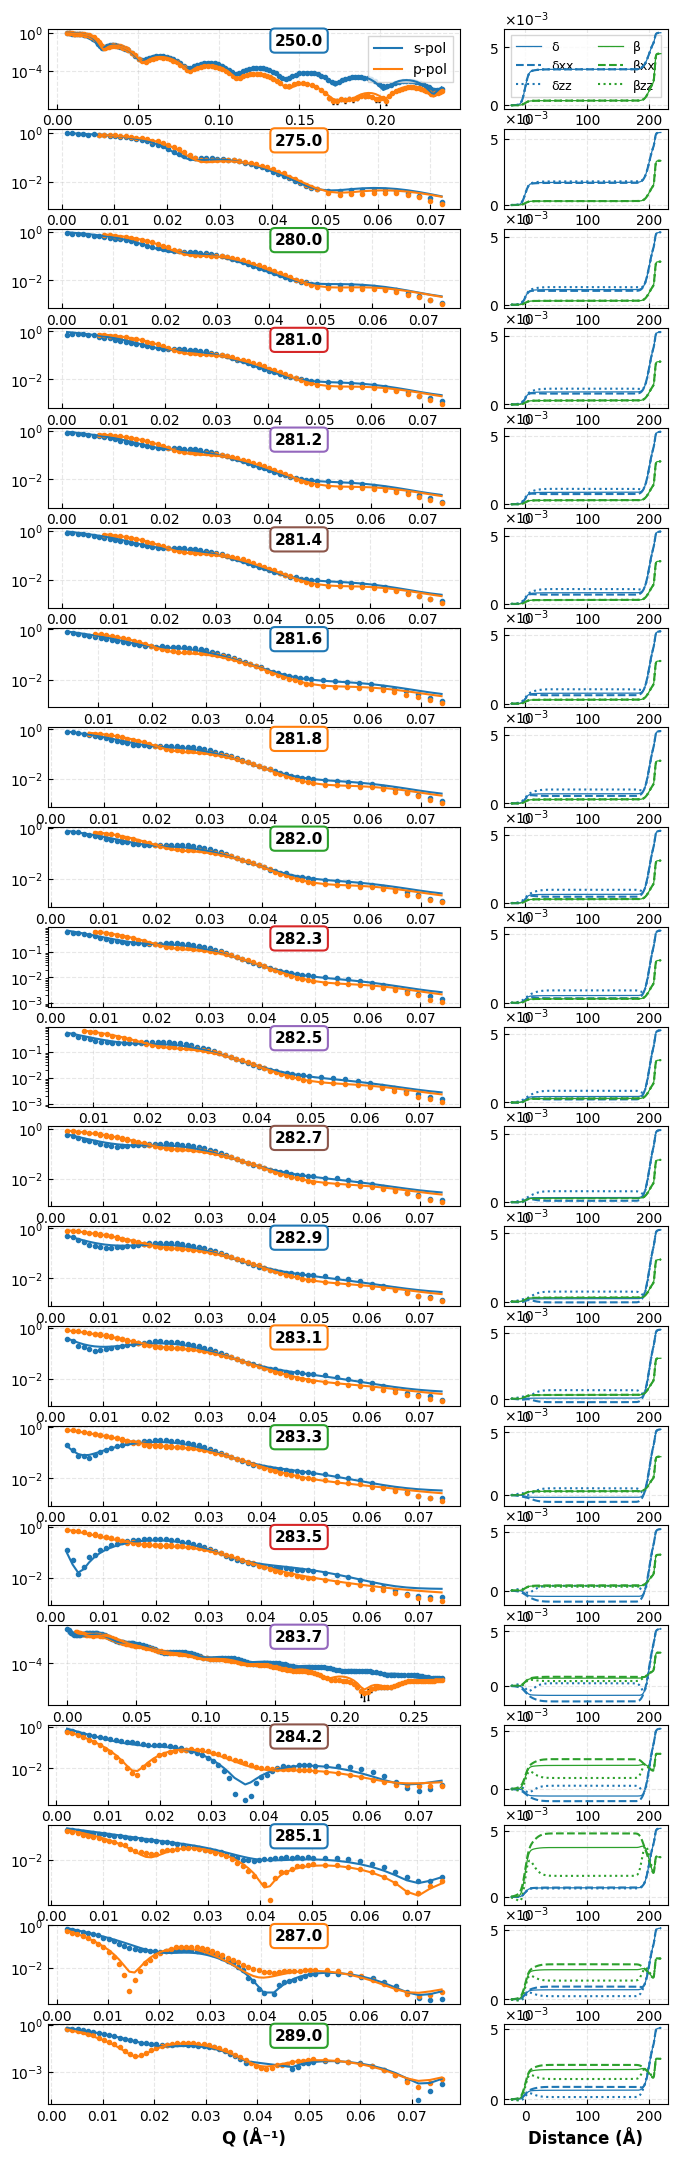

In [ ]:
from typing import Any

from matplotlib.figure import Figure


def plot_reflectivity_and_structure(global_obj, figsize=(12, 10)) -> tuple[Figure, Any]:
    """
    Plot reflectivity data and structure profiles for a global objective.

    Parameters:
    -----------
    global_obj : GlobalObjective
        The global objective containing multiple objectives
    stacks : dict
        Dictionary of structure stacks with energy keys
    energy_labels : list, optional
        List of energy labels for plotting. If None, uses stack keys.
    figsize : tuple, optional
        Figure size (width, height)

    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    objectives = global_obj.objectives
    energy_labels = [o.model.energy for o in objectives]
    stacks = {str(o.model.energy): o.model.structure for o in objectives}
    n_objectives = len(objectives)

    # Create figure and axes
    fig, ax = plt.subplots(
        nrows=n_objectives,
        ncols=2,
        figsize=figsize,
        gridspec_kw={
            "hspace": 0.25,
            "wspace": 0.15,
            "width_ratios": [2.5, 1],
        },
    )

    # Handle single objective case
    if n_objectives == 1:
        ax = ax.reshape(1, -1)

    # Define colors for consistency
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

    # Plot objectives and structures
    for i in range(n_objectives):
        if i >= len(objectives):
            break

        o = objectives[i]
        color = colors[i % len(colors)]

        # Plot reflectivity data
        o.plot(ax=ax[i][0], show_anisotropy=False)
        ax[i][0].set_ylabel(None, fontsize=12, fontweight="bold")
        ax[i][0].set_yscale("log")
        ax[i][0].grid(True, alpha=0.3, linestyle="--")
        ax[i][0].tick_params(direction="in", labelsize=10)

        # Add energy label as text box
        ax[i][0].text(
            0.55,
            0.95,
            energy_labels[i],
            transform=ax[i][0].transAxes,
            fontsize=11,
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=color,
                linewidth=1.5,
            ),
            verticalalignment="top",
            zorder=10,
        )

        # Custom legend for reflectivity
        if i == 0:
            ax[i][0].legend(
                ["s-pol", "p-pol"],
                loc="upper right",
                frameon=True,
                fancybox=False,
                fontsize=10,
            )
        else:
            if ax[i][0].get_legend():
                ax[i][0].get_legend().remove()

        # Plot structure (SLD profile)
        stack_key = list(stacks.keys())[i]
        stack = stacks[stack_key]
        stack.plot(ax=ax[i][1])
        ax[i][1].grid(True, alpha=0.3, linestyle="--")
        ax[i][1].tick_params(direction="in", labelsize=10)

        # Format y-axis for SLD to show in scientific notation
        ax[i][1].ticklabel_format(
            style="scientific", axis="y", scilimits=(0, 0), useMathText=True
        )

        # Remove individual legends except for the top structure plot
        if i == 0:
            ax[i][1].legend(
                loc="upper center",
                ncol=2,
                fontsize=9,
                frameon=True,
                fancybox=False,
            )
        else:
            if ax[i][1].get_legend():
                ax[i][1].get_legend().remove()

    # Set up x-axis labels
    ax[n_objectives - 1][0].set_xlabel("Q (Å⁻¹)", fontsize=12, fontweight="bold")

    # Set y-axis labels for structure plots
    for i in range(n_objectives):
        ax[i][1].set_ylabel(None, fontsize=12, fontweight="bold")
        if i < n_objectives - 1:
            ax[i][1].set_xlabel("")
        else:
            ax[i][1].set_xlabel("Distance (Å)", fontsize=12, fontweight="bold")

    # Set consistent x-axis limits for better comparison
    # for i in range(n_objectives):
    # ax[i][1].set_xlim(-10, 200)

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

    return fig, ax


plot_reflectivity_and_structure(fit_obj, figsize=(8, 25))
plt.show()

In [ ]:
from refnx.analysis import Parameters


def all_parameters(parameter_group):
    if isinstance(parameter_group, Parameters):
        params = []
        for param in parameter_group:
            params.extend(all_parameters(param))
        return params
    else:
        return [parameter_group]


# def print_parameters(obj, all_params=True):
#     """Print all parameters in the object."""
#     param_list = (
#         all_parameters(obj.parameters) if all_params else obj.varying_parameters()
#     )
#     print(f"Number of parameters: {len(param_list)}")
#     print(f"Varying parameters: {len(obj.varying_parameters())}")
#     print("-" * 82)
#     for param in param_list:
#         vary_status = "✓" if param.vary else "✗"fitting/fitting dynamics.ipynb
#         color = (
#             "\033[94m" if param.vary else "\033[91m"
#         )  # Light blue for vary=True, red for vary=False
#         reset_color = "\033[0m"  # Reset to default color
#         if param.stderr and param.stderr != 0:
#             stderr = sigfig.round(param.stderr, sigfigs=1)
#             val = round(param.value, -int(np.floor(np.log10(param.stderr))))
#             val_str = f"{val:10.3f}"
#             stderr_str = f"{stderr:g}"  # Remove trailing zeros
#         else:
#             stderr_str = "0"
#             val_str = (
#                 f"{param.value:10.3f}"
#                 if param.name != "bkg"
#                 else f"{param.value:10.3g}"
#             )

#         print(
#             f"|{color}{vary_status} | {param.name:30} | {val_str} ± {stderr_str:>8} | {str(param.bounds):18}{reset_color} |"
#         )
#     print("-" * 82)


# plt.show()
# print_parameters(fit_obj, all_params=False)

In [ ]:
def structure_params(fit_objectives, structure_property):
    """Get the structure parameters from the fit objectives."""
    #  Iterate over the obectives and grab the structure parameters
    params = []
    for objective in fit_objectives.objectives:
        for slab in objective.model.structure:
            if structure_property in ["density", "rotation"]:
                if hasattr(slab, "sld") and hasattr(slab.sld, structure_property):
                    param = getattr(slab.sld, structure_property)
                    if param.vary:
                        params.append(param)
            if hasattr(slab, structure_property):
                param = getattr(slab, structure_property)
                if param.vary:
                    params.append(param)
    return params


def print_structure_params(fit_objectives, structure_property):
    """Print the structure parameters from the fit objectives."""
    params = structure_params(fit_objectives, structure_property)
    print(f"Number of {structure_property} parameters: {len(params)}")
    print("-" * 82)
    for param in params:
        color = (
            "\033[94m" if param.vary else "\033[91m"
        )  # Light blue for vary=True, red for vary=False
        reset_color = "\033[0m"  # Reset to default color
        #  Round the param bounds to 3 decimal places
        bounds = (
            f"({param.bounds.lb:.3f}, {param.bounds.ub:.3f})"
            if param.bounds is not None
            else "(None, None)"
        )
        val = param.value
        err = param.stderr if param.stderr else 0
        print(
            f"{color}| {param.name:30} | {val:10.3f} ± {err:8.3f} | {str(bounds):18}{reset_color} |"
        )
    print("-" * 82)


print_structure_params(fit_obj, "thick")
print_structure_params(fit_obj, "rough")
print_structure_params(fit_obj, "density")
print_structure_params(fit_obj, "rotation")

Number of thick parameters: 4
----------------------------------------------------------------------------------
| Surface_283.7_thick            |      5.532 ±    0.323 | (0.000, 12.000)    |
| ZnPc_283.7_thick               |    183.323 ±    0.395 | (180.000, 210.000) |
| Contamination_283.7_thick      |     11.502 ±    0.321 | (0.000, 12.000)    |
| Oxide_283.7_thick              |      8.731 ±    0.170 | (8.000, 12.000)    |
----------------------------------------------------------------------------------
Number of rough parameters: 4
----------------------------------------------------------------------------------
| Surface_283.7_rough            |      4.412 ±    0.146 | (0.000, 5.000)     |
| ZnPc_283.7_rough               |     12.819 ±    0.240 | (2.000, 16.000)    |
| Contamination_283.7_rough      |      4.195 ±    0.331 | (0.000, 5.000)     |
| Oxide_283.7_rough              |      5.856 ±    0.075 | (0.000, 8.000)     |
---------------------------------------------------

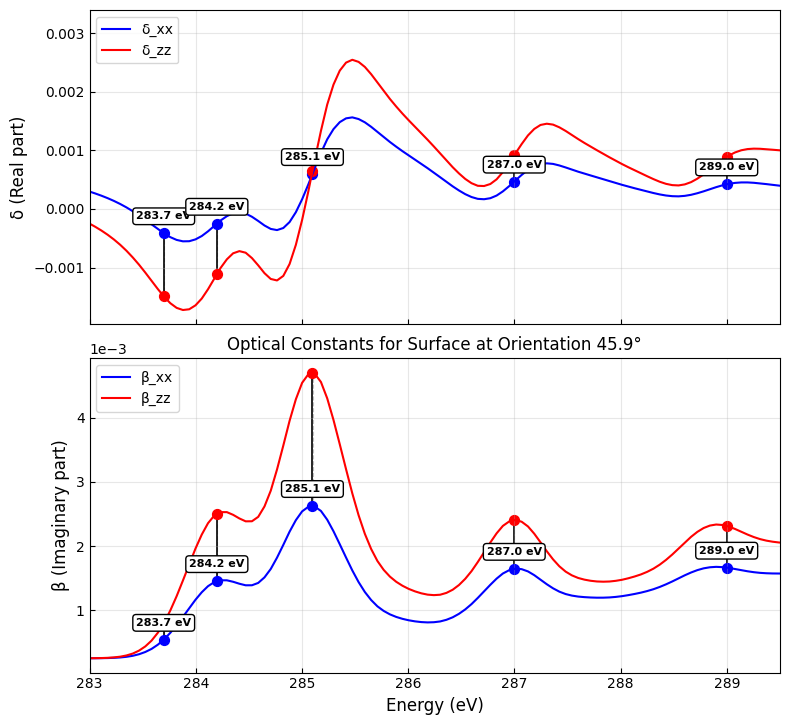

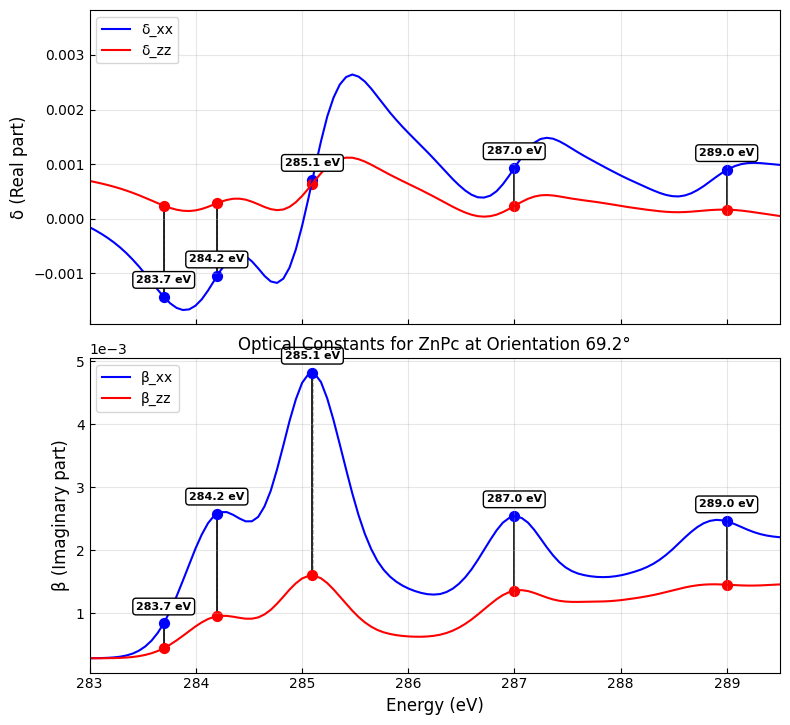

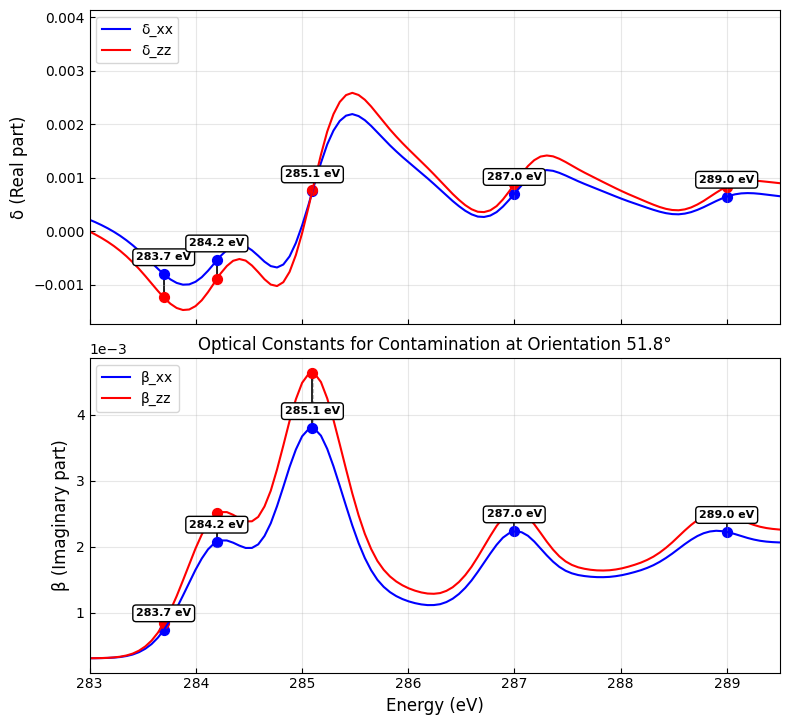

In [ ]:
#  Get the orientation of each layer
orientations = {}
densities = {}
for objective in fit_obj.objectives:
    for slab in objective.model.structure:
        slab_name = slab.name.split("_")[0]  # Get the slab name without the energy
        if hasattr(slab, "sld") and hasattr(slab.sld, "rotation"):
            if slab.sld.rotation.vary:
                orientations[slab_name] = slab.sld.rotation.value
            if hasattr(slab.sld, "density") and slab.sld.density.vary:
                densities[slab_name] = slab.sld.density.value

energy_offset = fit_obj.objectives[0].model.energy_offset.value

#  For each slab, plot the optical constants
for slab_name, orientation in orientations.items():
    plot_optical_constants_with_energies(
        ooc,
        energy_batches[1],
        en_shift=energy_offset,
        label=True,
        theta=orientation,
        density=densities.get(slab_name, 1.61),
        show_theta_range=False,
    )
    #  Set the x range and add a title
    plt.xlim(283, 289.5)
    plt.title(
        f"Optical Constants for {slab_name} at Orientation {np.degrees(orientation):.1f}°"
    )
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    #  Show the plot
plt.show()

In [ ]:
#  Fix the thickness, and roughness of all layers to the 283.7 eV values
def fix_structure_parameters(fit_objectives, structure_property):
    """Get the structure parameters from the fit objectives."""
    #  Iterate over the obectives and grab the structure parameters
    import copy

    objective = copy.deepcopy(fit_objectives)
    for obj in objective.objectives:
        for slab in obj.model.structure:
            if structure_property == "density":
                if hasattr(slab, "sld") and hasattr(slab.sld, structure_property):
                    param = getattr(slab.sld, structure_property)
                    if param.vary:
                        param.setp(vary=False)
            if hasattr(slab, structure_property):
                param = getattr(slab, structure_property)
                if param.vary:
                    param.setp(vary=False)
    return objective


obj_fixed = fix_structure_parameters(fit_obj, "thick")
obj_fixed = fix_structure_parameters(obj_fixed, "rough")

#  Fix the density for the Si and SiO2 layers to the 283.7 eV values
for obj in obj_fixed.objectives:
    if obj.model.structure[-1].sld.density.vary:
        obj.model.structure[-1].sld.density.setp(vary=False, value=2.33)
    if obj.model.structure[-2].sld.density.vary:
        obj.model.structure[-2].sld.density.setp(vary=False)

print_structure_params(obj_fixed, "thick")
print_structure_params(obj_fixed, "rough")
print_structure_params(obj_fixed, "density")
print_structure_params(obj_fixed, "rotation")

Number of thick parameters: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Number of rough parameters: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Number of density parameters: 3
----------------------------------------------------------------------------------
| Surface_283.7_density          |      1.466 ±    0.033 | (1.000, 1.800)     |
| ZnPc_283.7_density             |      1.654 ±    0.007 | (1.200, 1.800)     |
| Contamination_283.7_density    |      1.800 ±    0.015 | (1.000, 1.800)     |
----------------------------------------------------------------------------------
Number of rotation parameters: 3
----------------------------------------------------------------------------------
| Surface_283.7_rotation         |      0.802 ±    0.4

In [ ]:
#  Implement a monte carlo sampler over the rotations to determine what parameter
# space looks like